Dataset

In [ ]:
# API JSON
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download pandaa12/discord-reviews-indonesia-google-play-store
!mkdir -p data/raw
!unzip -o discord-reviews-indonesia-google-play-store.zip -d data/raw
!rm discord-reviews-indonesia-google-play-store.zip

Dataset URL: https://www.kaggle.com/datasets/pandaa12/discord-reviews-indonesia-google-play-store
License(s): apache-2.0
  0% 0.00/2.23M [00:00<?, ?B/s]
100% 2.23M/2.23M [00:00<00:00, 750MB/s]
Archive:  discord-reviews-indonesia-google-play-store.zip
  inflating: data/raw/ulasan_com.discord.csv  


In [ ]:
!ls data/raw

ulasan_com.discord.csv


In [ ]:
import pandas as pd

path = "data/raw/ulasan_com.discord.csv"
df = pd.read_csv(path)

df.head()


,Nama User,Ulasan,Rating,Tanggal,Likes,Versi App
0,Pengguna Google,aelah bug mic mulu heran gajelas bgt,3,2025-12-31 16:43:17,0,309.11 - Stable
1,Pengguna Google,"apk nya ngeragebait Mulu,aku login pake nomor ...",3,2025-12-31 16:22:12,0,309.11 - Stable
2,Pengguna Google,sangat berguna THX,1,2025-12-31 16:04:46,0,309.11 - Stable
3,Pengguna Google,mohon developer hilangkan saja previkasi nya a...,1,2025-12-31 15:24:34,0,NaN
4,Pengguna Google,"ini kenapa ya, setiap saya mau login gabisa bi...",3,2025-12-31 14:58:19,0,309.11 - Stable


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75141 entries, 0 to 75140
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Nama User  75141 non-null  object
 1   Ulasan     75139 non-null  object
 2   Rating     75141 non-null  int64 
 3   Tanggal    75141 non-null  object
 4   Likes      75141 non-null  int64 
 5   Versi App  43641 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


In [ ]:
df["Rating"].value_counts()

,count
Rating,
5,40137
1,20207
4,5757
3,5020
2,4020


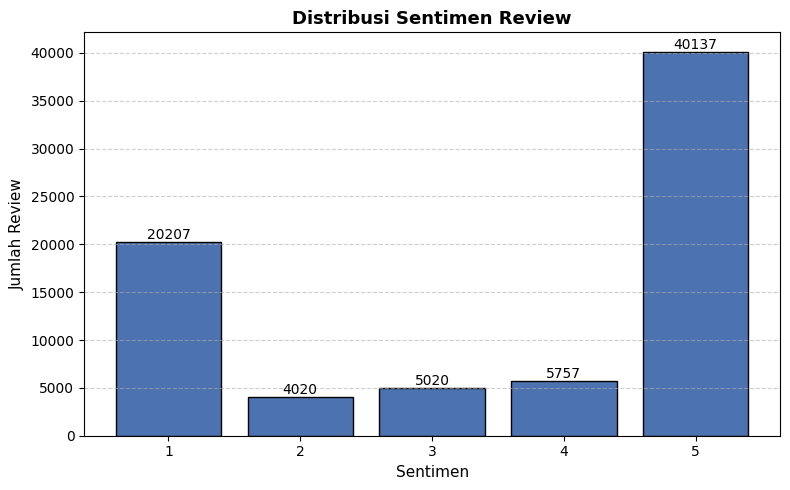

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

rating_counts = df["Rating"].value_counts().sort_index()

bars = plt.bar(
    rating_counts.index,
    rating_counts.values,
    color="#4C72B0",
    edgecolor="black"
)

plt.xlabel("Sentimen", fontsize=11)
plt.ylabel("Jumlah Review", fontsize=11)
plt.title("Distribusi Sentimen Review", fontsize=13, fontweight="bold")

plt.grid(axis="y", linestyle="--", alpha=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
df["Ulasan"].isna().sum()

np.int64(2)

In [ ]:
df["text_len"] = df["Ulasan"].str.len()
df.groupby("Rating")["text_len"].mean()

,text_len
Rating,
1,75.865641
2,93.409204
3,78.425498
4,58.550382
5,31.755332


In [ ]:
df[df["Rating"] == 1]["Ulasan"].sample(5)

,Ulasan
12054,Ngebug mulu bangsat apk burik gabisa dipencett...
55611,TOLONG!!! Suara dari discord kok patah patah+k...
62209,Saya tidak bisa masuk aplikasi
7675,Bug suara selalu ga kedengaran waktu telfon
13273,Aplikasi enggak guna mau buat akun nomor betul...


In [ ]:
df[df["Rating"] == 5]["Ulasan"].sample(5)

,Ulasan
56131,I LOVE YOU TO
23079,GG kalo buat growtopia
41871,Sangat bagus
2481,app horror
32752,Sangat bagus


Filter & Label

In [ ]:
df = df[["Ulasan", "Rating"]].dropna()

df = df[df["Rating"].isin([1, 2, 5])].copy()

df["label"] = df["Rating"].map({
    1: 0,  # negative
    2: 0,  # negative
    5: 1   # positive
})

df["label"].value_counts()

,count
label,
1,40136
0,24227


In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)     # remove URL
    text = re.sub(r"<.*?>", "", text)       # remove HTML
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["Ulasan"].apply(clean_text)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

Baseline TF IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5,
        max_df=0.9
    )),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=1000
    ))
])

model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[4404  442]
 [ 696 7331]]
              precision    recall  f1-score   support

           0     0.8635    0.9088    0.8856      4846
           1     0.9431    0.9133    0.9280      8027

    accuracy                         0.9116     12873
   macro avg     0.9033    0.9110    0.9068     12873
weighted avg     0.9132    0.9116    0.9120     12873



In [ ]:
import numpy as np

feature_names = model.named_steps["tfidf"].get_feature_names_out()
coef = model.named_steps["clf"].coef_[0]

top_pos = np.argsort(coef)[-20:]
top_neg = np.argsort(coef)[:20]

print("Top Positive Words:")
print(feature_names[top_pos])

print("\nTop Negative Words:")
print(feature_names[top_neg])


Top Positive Words:
['like' 'mabar' 'wow' 'mantab' 'thanks' 'great' 'mantep' 'oke' 'terbaik'
 'terimakasih' 'kalian' 'mantap' 'love' 'cool' 'bagus' 'not bad' 'nice'
 'good' 'best' 'keren']

Top Negative Words:
['login' 'tidak' 'malah' 'padahal' 'bug' 'susah' 'ribet' 'mulu' 'ga'
 'gabisa' 'verifikasi' 'gak' 'update' 'sering' 'kenapa' 'gk' 'akun'
 'buruk' 'sampah' 'why']


In [ ]:
import numpy as np

feature_names = model.named_steps["tfidf"].get_feature_names_out()
coef = model.named_steps["clf"].coef_[0]

positive_words = {
    feature_names[i]: coef[i]
    for i in np.argsort(coef)[-100:]
}

negative_words = {
    feature_names[i]: -coef[i]
    for i in np.argsort(coef)[:100]
}

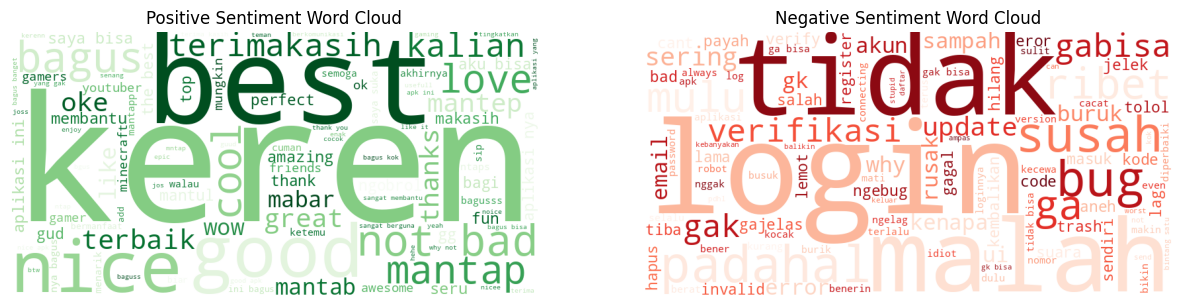

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc_pos = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Greens"
).generate_from_frequencies(positive_words)

wc_neg = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Reds"
).generate_from_frequencies(negative_words)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_pos)
plt.axis("off")
plt.title("Positive Sentiment Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(wc_neg)
plt.axis("off")
plt.title("Negative Sentiment Word Cloud")

plt.show()

Error Analysis

In [ ]:
import pandas as pd

X_test_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_pred
})

X_test_df["error"] = X_test_df["true_label"] != X_test_df["pred_label"]

In [ ]:
false_positive = X_test_df[
    (X_test_df["true_label"] == 0) & (X_test_df["pred_label"] == 1)
]

false_negative = X_test_df[
    (X_test_df["true_label"] == 1) & (X_test_df["pred_label"] == 0)
]


In [ ]:
false_positive.sample(10, random_state=42)["text"].tolist()

['2 dlu aja ya',
 'peler',
 'spam',
 'aplikasi sangad bagus',
 'geme nya gak seru',
 '',
 'please add a live stream feature in mobile if it s been added then i ll change the rating to a five star thank you',
 'woi kwan ak dh turun tangan tu ha fazek namanya ak kasih waktu sampe besok ya klo ga mau juga diskort ni lapor polisi',
 'ga tau cara live',
 'harus imel']

In [ ]:
false_negative.sample(10, random_state=42)["text"].tolist()

['bagaimana cara untuk mendapatkan kode verifikasi dalam bentuk sms aku butuh jawabannya',
 'kenapa saya tidak bisa dowload',
 'the only problem is when i playing pubg or any game discord automatically force close idk why',
 'kenapa saya tidak bisa meng instal aplikasi',
 'goblok aplikasi in',
 'no trouble anymore',
 'bgus tpi suara suka hilang sndri',
 'woeeee server indo kok ada buleeeee',
 'aku harap nanti ada fitur translate otomatisnya dan bahasa indonesia',
 'saat teman saya melakukan share screnn selalu tidak muncul suara padahal semua settingan sudah hidup tolong diperbaiki']

In [ ]:
X_test_df["text_len"] = X_test_df["text"].str.len()

X_test_df.groupby("error")["text_len"].mean()


,text_len
error,
False,46.760886
True,53.031634


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=5, stop_words=None)

fp_terms = cv.fit_transform(false_positive["text"])
fn_terms = cv.fit_transform(false_negative["text"])

Drop <5 word Sentence

In [ ]:
before_count = len(df)

df = df[df["clean_text"].str.len() >= 5].copy()

after_count = len(df)

print(f"Before Dropping : {before_count}")
print(f"After Drop : {after_count}")
print(f"Dropped Count : {before_count - after_count}")


Before Dropping : 64363
After Drop : 55807
Dropped Count : 8556


In [ ]:
df["label"].value_counts()

,count
label,
1,31990
0,23817


TRANSFORMER BASED MODEL

In [ ]:
!huggingface-cli login


⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `unet` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cach

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "indolem/indobert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_texts(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )


In [ ]:
import torch
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize_texts(texts)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


In [ ]:
train_dataset = ReviewDataset(X_train, y_train)
test_dataset  = ReviewDataset(X_test, y_test)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./indobert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none"
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-3446133423.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.248500,0.254693,0.904945,0.906890,0.904945,0.905256
2,0.220500,0.252585,0.910321,0.910986,0.910321,0.910485
3,0.189500,0.249105,0.912471,0.912961,0.912471,0.912604


TrainOutput(global_step=4188, training_loss=0.23222393110579498, metrics={'train_runtime': 3023.0943, 'train_samples_per_second': 44.304, 'train_steps_per_second': 1.385, 'total_flos': 8809944799910400.0, 'train_loss': 0.23222393110579498, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[4337  427]
 [ 550 5848]]
              precision    recall  f1-score   support

           0     0.8875    0.9104    0.8988      4764
           1     0.9320    0.9140    0.9229      6398

    accuracy                         0.9125     11162
   macro avg     0.9097    0.9122    0.9108     11162
weighted avg     0.9130    0.9125    0.9126     11162



## Conclusion and Quantitative Analysis

This study evaluates a classical TF-IDF–based model and a Transformer-based model (IndoBERT) for binary sentiment classification on Indonesian Discord application reviews.

### Baseline Performance
The TF-IDF + Logistic Regression baseline achieves strong results with an accuracy of **91.16%** and a weighted F1-score of **0.9120**. The confusion matrix indicates **442 false positives** (negative reviews predicted as positive) and **696 false negatives** (positive reviews predicted as negative). Despite its simplicity, the baseline model effectively captures dominant sentiment cues and serves as a robust reference point.

### Transformer-Based Performance
Fine-tuning IndoBERT results in a comparable overall accuracy of **91.25%** and a weighted F1-score of **0.9126**. While the absolute gain in aggregate metrics is marginal, a detailed error comparison reveals meaningful qualitative improvements. Specifically, the number of false negatives decreases from **696 to 550**, representing a reduction of approximately **21%**. This indicates improved recognition of positive sentiment in longer and more context-rich reviews.

False positives are also reduced slightly, from **442 to 427**, suggesting that the Transformer model is marginally more conservative when assigning positive sentiment. However, both models remain challenged by extremely short or low-information reviews.

### Error Characteristics
Error analysis shows that misclassified samples tend to have longer average text length (**~53 characters**) compared to correctly classified samples (**~47 characters**). Many errors involve mixed sentiment, contrastive structures (e.g., "good but…"), informal spelling variations, or rating-text inconsistencies. In several cases, the Transformer prediction aligns better with the linguistic content of the review, while the rating-derived label appears noisy.

### Interpretation
The limited improvement in aggregate metrics can be attributed to two main factors:
1. The baseline model is already highly optimized for this dataset.
2. Rating-based weak supervision introduces unavoidable label noise that constrains achievable performance.

Despite this, the reduction in false negatives demonstrates that the Transformer model provides superior contextual understanding, particularly for complex or nuanced reviews. These findings suggest that performance gains from Transformer-based models in real-world review data should be evaluated not only through accuracy but also through changes in error distribution and error type.

Overall, the results justify the use of IndoBERT when contextual accuracy and qualitative error reduction are prioritized, while also highlighting the strong competitiveness of classical baselines for cost-sensitive or low-latency applications.


In [ ]:

for i in range(5):
    print("TEXT :", X_test[i])
    print("TRUE :", y_test[i], "PRED :", y_pred[i])
    print("-" * 50)


TEXT : pas main game gambar malah dihp ga bisa main kadang black screen zoom sampe ga bisa gambar tolong diperbaiki segera
TRUE : 0 PRED : 0
--------------------------------------------------
TEXT : kenapa pas telp sendiri jadi di batasin 3 menit
TRUE : 0 PRED : 0
--------------------------------------------------
TEXT : bola bali nggo dolanan
TRUE : 0 PRED : 0
--------------------------------------------------
TEXT : susah banget sih login nya
TRUE : 0 PRED : 0
--------------------------------------------------
TEXT : bagus aplikasinya seru bisa ngobrol sama temen yg di sana yg ga kenal jadi kenal
TRUE : 1 PRED : 1
--------------------------------------------------


In [ ]:
import os

BERT_SAVE_PATH = "./models/indobert_sentiment"

os.makedirs(BERT_SAVE_PATH, exist_ok=True)

In [ ]:
trainer.save_model(BERT_SAVE_PATH)
tokenizer.save_pretrained(BERT_SAVE_PATH)


('./models/indobert_sentiment/tokenizer_config.json',
 './models/indobert_sentiment/special_tokens_map.json',
 './models/indobert_sentiment/vocab.txt',
 './models/indobert_sentiment/added_tokens.json',
 './models/indobert_sentiment/tokenizer.json')

In [ ]:
import shutil

shutil.make_archive('indobert_results', 'zip', 'indobert_results')

shutil.make_archive('models', 'zip', 'models')

'/content/models.zip'

In [ ]:
from google.colab import files

files.download('indobert_results.zip')
files.download('models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>